In [1]:
import datetime
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
  
# initialize parameters
start_date = datetime(2020, 3, 1)
end_date = datetime(2021, 3, 1)
  
# get the data
data = yf.download('AMZN', start = start_date,
                   end = end_date)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,1906.489990,1954.510010,1870.000000,1953.949951,1953.949951,6761700
2020-03-03,1975.369995,1996.329956,1888.089966,1908.989990,1908.989990,7534500
2020-03-04,1946.569946,1978.000000,1922.000000,1975.829956,1975.829956,4772900
2020-03-05,1933.000000,1960.719971,1910.000000,1924.030029,1924.030029,4748200
2020-03-06,1875.000000,1910.869995,1869.500000,1901.089966,1901.089966,5273600
...,...,...,...,...,...,...
2021-02-22,3208.129883,3232.320068,3172.260010,3180.739990,3180.739990,3515700
2021-02-23,3127.030029,3204.729980,3093.600098,3194.500000,3194.500000,4677200
2021-02-24,3166.750000,3171.229980,3125.379883,3159.530029,3159.530029,3011300


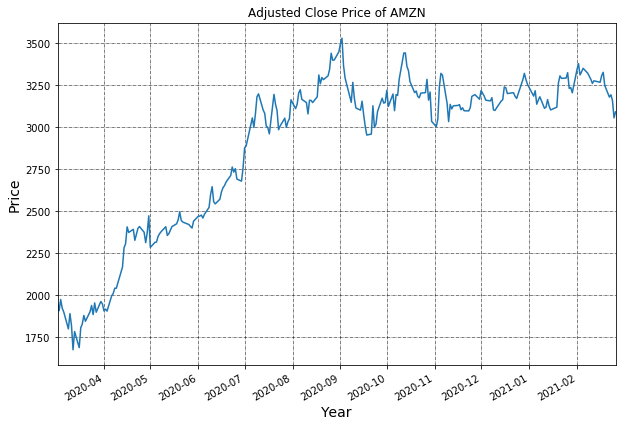

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the adjusted close price
data['Adj Close'].plot(figsize=(10, 7))
# Define the label for the title of the figure
plt.title("Adjusted Close Price of AMZN")
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
# Show the plot
plt.show()

In [6]:
import numpy as np

data['Log returns'] = np.log(data['Adj Close']/data['Adj Close'].shift())
data['Log returns']

Date
2020-03-02         NaN
2020-03-03   -0.023279
2020-03-04    0.034414
2020-03-05   -0.026567
2020-03-06   -0.011995
                ...   
2021-02-22   -0.021510
2021-02-23    0.004317
2021-02-24   -0.011007
2021-02-25   -0.032937
2021-02-26    0.011632
Name: Log returns, Length: 251, dtype: float64

In [4]:
volatility_12m = data['Log returns'].std()*252**.5
volatility_12m

0.3794292915174012

Text(0.5, 1.0, 'AMZN 12m volatility: 37.940000000000005%')

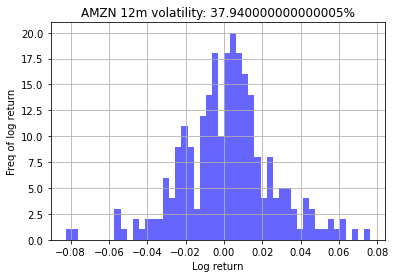

In [5]:
str_vol = str(round(volatility_12m, 4)*100)

fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("AMZN 12m volatility: " + str_vol + "%")

In [6]:
volatility_6m = data['Log returns'].std()*126**.5
volatility_6m

0.26829702501276176

Text(0.5, 1.0, 'AMZN 6m volatility: 26.83%')

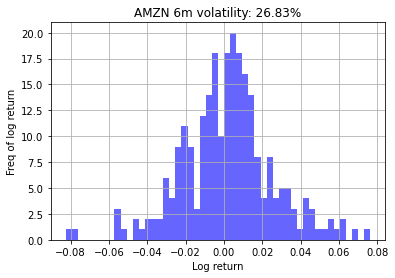

In [16]:
str_vol = str(round(volatility_6m, 4)*100)

fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("AMZN 6m volatility: " + str_vol + "%")

In [11]:
import numpy as np
import os
S0 = 1953.95              # spot stock price
K = 1960               # strike
T = 4/52                 # maturity 
r = 0.0014                 # risk free rate 
sig = 0.3794             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff

dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor
##__________________________________________________________________________________
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
##____________________________________________________________________________________
S
##_________________________________________________________________________________
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p
##_____________________________________________________________________________________
### Step 2: Find option value at each final node
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.where (S_T>=K,1, 0.0)  
elif payoff =="put":
    V[:,-1] = np.where (K>S_T,1,0.0)  
    V
##_____________________________________________________________________________________
### Step 3: Find option value at earlier nodes
# for Binary Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
        V
#___________________________________________________________________________________
print('Binary ' + payoff, str( V[0,0]))

Binary put 0.5222694862455405


In [16]:
#Monte Carlo Simulation (MC)
import datetime
import math
from random import gauss
from math import exp, sqrt

def generate_asset_price(S,v,r,T):
    return S * exp((r - 0.5 * v**2) * T + v * sqrt(T) * gauss(0,1.0))

def call_payoff(S_T,K):
    return max(0.0,S_T-K)

S = 1953.95  # underlying price
v = 0.3794 # vol of 37.94%
r = 0.0014 # rate of 0.14%
T = 30
K = 1960
simulations = 90000
payoffs = []
discount_factor = math.exp(-r * T)

for i in list(range(simulations)):
    S_T = generate_asset_price(S,v,r,T)
    payoffs.append(
        call_payoff(S_T, K)
    )

price = discount_factor * (sum(payoffs) / float(simulations))
print('Price: %.4f' % price)

Price: 1358.0483


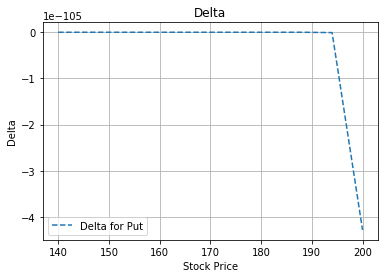

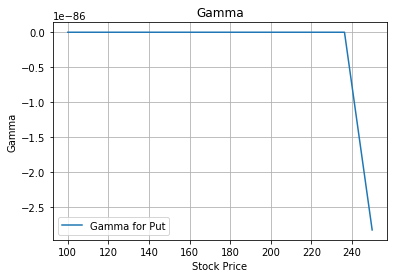

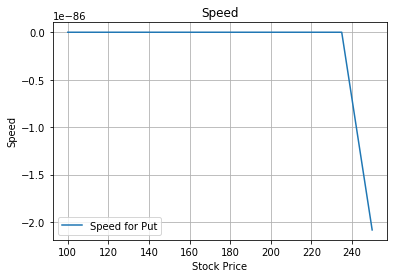

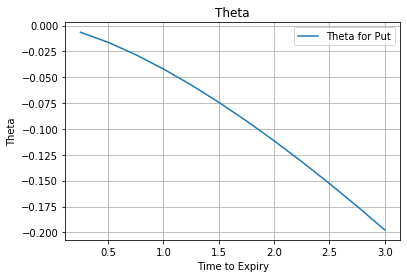

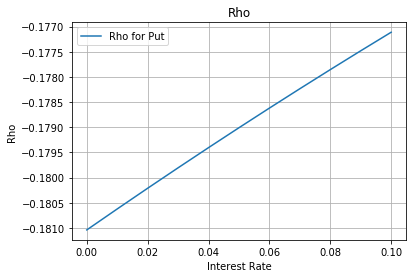

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

#Delta :

def delta(S,K,T,r,vol):
    d2=(np.log(S/K)+(r-0.5*vol**2)*T)/(vol*np.sqrt(T))
    delta=-np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)/(vol*S*np.sqrt(T))
    return delta
#__________________________________________________________________________

delta(1953.95,1960,4/52,0.0014,0.3794)
#__________________________________________________________________________
#
S=np.linspace(140,200,11)
Delta_Put=np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Put[i]=delta(S[i],1960,4/52,0.0014,0.3794)
#__________________________________________________________________________

fig=plt.figure()
plt.plot(S,Delta_Put,'--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])
#__________________________________________________________________________


#Gamma :
def gamma(S,K,T,r,vol):
    d1=(np.log(S/K)+(r+0.5*vol**2)*T)/(vol*np.sqrt(T))
    d2=(np.log(S/K)+(r-0.5*vol**2)*T)/(vol*np.sqrt(T))
    gamma=(np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*T)
    return gamma

gamma(1953.95,1960,4/52,0.0014,0.3794)


S =np.linspace(100,250,12)
Gamma =np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 1960,4/52,0.0014,0.3794)
#_____________________________________________________________________________

fig=plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

#Speed :

def speed(S,E,T,r,vol):
    d1=(np.log(S/E)+(r+0.5*vol**2)*T)/(vol*np.sqrt(T))
    d2=(np.log(S/E)+(r-0.5*vol**2)*T)/(vol*np.sqrt(T))
    speed_put=(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)/(vol**2*S**3*T))*(-2*d1+(1-(d1*d2))/(vol*np.sqrt(T)))
    return speed_put
 

speed(1953.95,1960,4/52,0.0014,0.3794)
S =np.linspace(100,250,11)
Speed =np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 1960, 4/52, 0.0014, 0.3794)
#_____________________________________________________________________________

fig=plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])



#Theta :
def theta(S, K, T, r,vol):
    d1 = (np.log(S / K) + (r +0.5*vol**2) * T) / (vol*np.sqrt(T))
    d2 = (np.log(S / K) + (r -0.5*vol**2) * T) / (vol*np.sqrt(T))
    theta= r *np.exp(-r * T) * (1-si.norm.cdf(d2, 0.0, 1.0)) -np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) * ((d1/2* T) - r/vol*np.sqrt(T))
    return theta
#_____________________________________________________________________________

theta(1953.95,1960,4/52,0.0014,0.3794)
T =np.linspace(0.25,3,12)
Theta_Put=np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Put [i] =theta(1983.52, 1960, T[i], 0.0014,0.3794)
#_____________________________________________________________________________

fig=plt.figure()
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

#Rho :
def rho(S,E,T,r,vol):

    d2= (np.log(S/E)+(r-0.5*vol**2)*T)/(vol*np.sqrt(T))
    rho =- T *np.exp(-r * T) * (1-si.norm.cdf(d2,0.0,1.0)) -(si.norm.cdf(-np.sqrt(T)/vol)*np.exp(-r * T) * (1-si.norm.pdf(d2,0.0,1.0)))   
    return rho
#_____________________________________________________________________________

rho(1953.95,1960,4/52,0.0014,0.3794)
#_____________________________________________________________________________
r =np.linspace(0,0.1,11)
Rho_Put=np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Put [i] =rho(1953.52, 1960, 4/52, r[i], 0.3794)
#_____________________________________________________________________________

fig=plt.figure()
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Put'])
#________________________________
